In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os
import cell2location
import scvi

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=60, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

import seaborn as sns
from pathlib import Path

custom_params = {"font.size": FONTSIZE, "figure.dpi": 100, "savefig.dpi": DPI}
sns.set_theme(style="ticks", rc=custom_params)

# QC utils functions - a package
from vistools import utils
from vistools import spatial_plots

Global seed set to 0


In [2]:
SAMPLE_NAME = "concat_withWu2022" #"Wu2022_ST_LM4"

if "concat_withWu2022" in SAMPLE_NAME:
    # load cell2location results
    DIR2LOAD = Path(
        f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/{SAMPLE_NAME}"
    )
    DIR2LOAD.mkdir(parents=True, exist_ok=True)

    run_name = DIR2LOAD.joinpath(f"cell2location_map-no_cycling_TME/")
    run_name.mkdir(parents=True, exist_ok=True)

    # load gene expression
    DIR2GENEXP = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/{SAMPLE_NAME}/{SAMPLE_NAME}_raw.h5ad")
    adata_genexp = sc.read_h5ad(DIR2GENEXP)
    
# load joint analysis of microenvrionmentts
MICROENV_DIR = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2loc_spatialde2/concat_withWu2022/")
adata_microenv = sc.read_h5ad(MICROENV_DIR.joinpath("sp_segmentation_smoothness1.2.h5ad"))

In [3]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2loc_spatialde2/concat_withWu2022/microenvs_geneexp/gene_signatures/")
# figures
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = FIG2SAVE

In [4]:
# only select spots that are in adata_genexpx
adata_microenv = adata_microenv[adata_microenv.obs.index.isin(adata_genexp.obs.index)].copy()

In [5]:
adata_microenv.shape

(16108, 55)

In [6]:
# create adata gene exp with microenv assignment
adata_genexp.obs = adata_genexp.obs.merge(adata_microenv.obs[["segmentation_labels"]],
                       how="left",
                       left_index=True,
                       right_index=True
                      )

In [7]:
### log normalise 
# keep raw
adata_genexp.layers["raw"] = adata_genexp.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata_genexp, target_sum=1e4, inplace=True)
adata_genexp.layers["normalised"] = adata_genexp.X.copy()
sc.pp.log1p(adata_genexp)

adata_genexp.layers["log1p"] = adata_genexp.X.copy()

adata_genexp.raw = adata_genexp  # keep normalised log1p

In [8]:
adata_genexp.obs.segmentation_labels.cat.categories

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [9]:
gene_sets = {
    "HALLMARK_HYPOXIA":  pd.read_table("/data/BCI-CRC/SO/genesets/HALLMARK_HYPOXIA.v7.5.1.grp"),
    "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION": pd.read_table("/data/BCI-CRC/SO/genesets/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.v7.5.1.grp"),
    "COAD_pEMT": pd.read_csv("/data/BCI-CRC/SO/genesets/COAD_pEMT_genes_TylerTirosh2021_tumourSpecific.csv"),
    "HALLMARK_INTERFERON_ALPHA_RESPONSE": pd.read_table("/data/BCI-CRC/SO/genesets/HALLMARK_INTERFERON_ALPHA_RESPONSE_M5911.txt"),
    "WNT SIGNALING": pd.read_table("/data/BCI-CRC/SO/genesets/HALLMARK_WNT_BETA_CATENIN_SIGNALING.v7.5.1.grp"),
    "HALLMARK_INTERFERON_GAMMA_RESPONSE": pd.read_table("/data/BCI-CRC/SO/genesets/HALLMARK_INTERFERON_GAMMA_RESPONSE_M5913.txt")
}
gene_sets["COAD_pEMT"].rename(columns={"COAD": "COAD_pEMT"}, inplace=True)
gene_sets["WNT SIGNALING"].rename(columns={"HALLMARK_WNT_BETA_CATENIN_SIGNALING": "WNT SIGNALING"}, inplace=True)

In [10]:
for i in gene_sets.keys():
    
    sc.tl.score_genes(adata_genexp, gene_list=gene_sets[i][i], score_name=i, use_raw=True)
    
    for samp in set(adata_genexp.obs.Sample):
        adata_tmp = utils.select_slide(adata_genexp, s=samp, batch_key="Sample")
        sc.pl.spatial(adata_tmp, color=i, size=1.3, img_key="hires", vmin=0, vmax="p99.2", 
                  cmap="YlGnBu", alpha_img=0.3, save=f"{samp}_{i}_vmin.pdf", show=False)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


### Load signatures from Hallmarks of transcriptional intratumour heterogeneity across a thousand tumours paper 2023 Gavish

In [11]:
gavish_sign = pd.read_excel("/data/BCI-CRC/nasrine/data/gene_sets/gavishHallmarksTranscriptio2023_41586_2023_6130_MOESM6_ESM.xlsx",
                            sheet_name="Cancer MPs",
                           )
gavish_sign.head(5)

,MP1 Cell Cycle - G2/M,MP2 Cell Cycle - G1/S,MP3 Cell Cylce HMG-rich,MP4 Chromatin,MP5 Stress,MP6 Hypoxia,MP7 Stress (in vitro),MP8 Proteasomal degradation,MP9 Unfolded protein response,MP10 Protein maturation,...,MP32 Skin-pigmentation,MP33 RBCs,MP34 Platelet-activation,MP35 Hemato-related-I,MP36 IG,MP37 Hemato-related-II,MP38 Glutathione,MP39 Metal-response,MP40 PDAC-related,MP41 Unassigned
0,TOP2A,PCNA,STMN1,MT-ND6,ATF3,NDRG1,DDIT3,PSMA3,PDIA3,RPN2,...,PHACTR1,BLVRB,RGS18,CSF3R,IGLC2,CTNNBL1,NAT8,MT1X,ISG20,DST
1,UBE2C,RRM2,TUBA1B,DST,EGR1,BNIP3,SLC3A2,PSMC4,MANF,PDIA3,...,TBC1D7,HBB,PDLIM1,SPINK2,IGLC3,FCER1A,ACSM2B,CAV1,KLK10,KMT2A
2,HMGB2,FEN1,H2AFZ,SMARCA5,FOS,SLC2A1,TRIB3,MDH1,PDIA4,ATP6AP2,...,MLANA,APOC1,ITGA2B,VAMP5,IGHA2,GATA2,LGALS2,MT1E,CEACAM1,MALAT1
3,NUSAP1,GINS2,DUT,SPEN,PPP1R15A,P4HA1,ASNS,PRDX1,CRELD2,HSPA5,...,ASAH1,CA1,PLEK,AZU1,IGHA1,CD84,AMN,C5ORF46,F3,MIR6515
4,CENPF,TYMS,TUBB,PCM1,JUN,VEGFA,HERPUD1,PSMA4,HSPA5,PDIA6,...,DCT,HBD,C6ORF25,SELL,IGHG4,PDZD8,BBOX1,TGFBI,LMO7,AKAP9


In [12]:
gavish_sign.columns

Index(['MP1  Cell Cycle - G2/M', 'MP2  Cell Cycle - G1/S',
       'MP3  Cell Cylce HMG-rich', 'MP4  Chromatin ', 'MP5 Stress ',
       'MP6 Hypoxia', 'MP7 Stress (in vitro)', 'MP8 Proteasomal degradation',
       'MP9 Unfolded protein response', 'MP10 Protein maturation',
       'MP11 Translation initiation', 'MP12 EMT-I', 'MP13 EMT-II',
       'MP14 EMT-III ', 'MP15 EMT IV', 'MP16 MES (glioma)',
       'MP17 Interferon/MHC-II (I)', 'MP18 Interferon/MHC-II (II)',
       'MP19 Epithelial Senescence', 'MP20 MYC', 'MP21 Respiration',
       'MP22 Secreted I', 'MP23 Secreted II', 'MP24 Cilia', 'MP25 Astrocytes',
       'MP26 NPC Glioma', 'MP27 Oligo Progenitor', 'MP28 Oligo normal',
       'MP29 NPC/OPC', 'MP30 PDAC-classical', 'MP31 Alveolar',
       'MP32 Skin-pigmentation', 'MP33 RBCs', 'MP34 Platelet-activation',
       'MP35 Hemato-related-I', 'MP36 IG', 'MP37 Hemato-related-II',
       'MP38 Glutathione', 'MP39 Metal-response', 'MP40 PDAC-related',
       'MP41 Unassigned'],
      dt

In [13]:
for i in ['MP6 Hypoxia', 'MP12 EMT-I', 'MP13 EMT-II', 'MP14 EMT-III ', 'MP15 EMT IV',
          'MP17 Interferon/MHC-II (I)', 'MP18 Interferon/MHC-II (II)',]:
    
    my_title = i.split("/")[0]
    
    sc.tl.score_genes(adata_genexp, gene_list=gavish_sign[i], score_name=i,
                      use_raw=True)
    
    for samp in set(adata_genexp.obs.Sample):
        adata_tmp = utils.select_slide(adata_genexp, s=samp, batch_key="Sample")
        #sc.tl.score_genes(adata_tmp, gene_list=gavish_sign[i], score_name=i, use_raw=True)
        sc.pl.spatial(adata_tmp, color=i, size=1.3, img_key="hires", vmin="p25.0", vmax="p99.2", title=my_title,
                  cmap="YlGnBu", alpha_img=0.3, save=f"Gavish2023_{samp}_{my_title}.pdf", show=False) # RdPu vmin=0.2

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [14]:
geneset_dict_sam = dict()

### EpiHR
geneSet = pd.read_csv('/data/BCI-CRC/Elise/genesets/Canellas_2022_gene_sig.csv')
geneSet['EpiHR'].dropna()
geneset_dict_sam['EpiHR'] = list(geneSet['EpiHR'].dropna())

### CRIS scores from Isella 2017
CRIS = pd.read_csv('/data/BCI-CRC/SO/genesets/Isella2017_CRIS_genes.csv')
#geneset_dict_sam['CRISA'] = [i for i in list(CRIS.iloc[:,0]) if str(i) != 'nan']
geneset_dict_sam['CRISB'] = [i for i in list(CRIS.iloc[:,1]) if str(i) != 'nan']

In [15]:
set(geneset_dict_sam['EpiHR']).intersection(set(geneset_dict_sam['CRISB']))

{'COL17A1',
 'ITGA3',
 'KLK10',
 'KLK6',
 'KRT17',
 'KRT6A',
 'KRT80',
 'LEMD1',
 'MSLN',
 'SERPINB5',
 'SFTA2',
 'SLPI',
 'TM4SF4'}

In [17]:
for i in geneset_dict_sam:
    
    my_title = i.split("/")[0]
    
    sc.tl.score_genes(adata_genexp, gene_list=geneset_dict_sam[i], score_name=i,
                      use_raw=True)
    
    for samp in set(adata_genexp.obs.Sample):
        adata_tmp = utils.select_slide(adata_genexp, s=samp, batch_key="Sample")
        #sc.tl.score_genes(adata_tmp, gene_list=gavish_sign[i], score_name=i, use_raw=True)
        sc.pl.spatial(adata_tmp, color=i, size=1.3, img_key="hires", vmin="p25.0", vmax="p99.2", title=my_title,
                  cmap="YlGnBu", alpha_img=0.3, save=f"SamSignatures_{samp}_{my_title}.pdf", show=False) # RdPu vmin=0.2

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


### boxplot across neighbourhoods

In [18]:
adata_genexp.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts',
       'total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'Sample_source',
       'Sample_name', 'segmentation_labels', 'HALLMARK_HYPOXIA',
       'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'COAD_pEMT',
       'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'WNT SIGNALING',
       'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'MP6 Hypoxia', 'MP12 EMT-I',
       'MP13 EMT-II', 'MP14 EMT-III ', 'MP15 EMT IV',
       'MP17 Interferon/MHC-II (I)', 'MP18 Interferon/MHC-II (II)', 'EpiHR',
       'CRISB'],
      dtype='object')

In [19]:
sign_score_df = adata_genexp.obs.loc[:, ['Sample_name', 'segmentation_labels', 
                                         'MP6 Hypoxia', 'MP13 EMT-II', 
                                         'MP17 Interferon/MHC-II (I)',
                                         'WNT SIGNALING', 'EpiHR'
                                        ]].copy()

In [20]:
sign_score_df.columns

Index(['Sample_name', 'segmentation_labels', 'MP6 Hypoxia', 'MP13 EMT-II',
       'MP17 Interferon/MHC-II (I)', 'WNT SIGNALING', 'EpiHR'],
      dtype='object')

In [21]:
sign_score_df.rename(columns={'MP17 Interferon/MHC-II (I)': 'MP17 Interferon', 
                              'WNT SIGNALING': 'WNT Signaling'}, inplace=True)

In [22]:
sign_score_df

,Sample_name,segmentation_labels,MP6 Hypoxia,MP13 EMT-II,MP17 Interferon,WNT Signaling,EpiHR
spot_id,,,,,,,
CRC08_LM_VISIUM_AAACAAGTATCTCCCA-1,CRC08_LM_VISIUM,4,0.289848,0.121464,-0.095485,0.094594,0.014283
CRC08_LM_VISIUM_AAACCGGAAATGTTAA-1,CRC08_LM_VISIUM,7,0.469770,0.349450,-0.007311,0.132064,0.122084
CRC08_LM_VISIUM_AAACCGTTCGTCCAGG-1,CRC08_LM_VISIUM,8,0.203719,0.162094,-0.145205,0.040817,0.093030
CRC08_LM_VISIUM_AAACCTAAGCAGCCGG-1,CRC08_LM_VISIUM,7,0.757316,0.327827,0.213807,0.087286,0.253953
CRC08_LM_VISIUM_AAACGAGACGGTTGAT-1,CRC08_LM_VISIUM,4,0.290556,0.410785,0.202215,-0.027821,0.022408
...,...,...,...,...,...,...,...
ST_LM_4_TTGTTGTGTGTCAAGA-1,Wu2022_ST_LM4,7,0.479064,0.572907,0.215697,-0.003601,0.058843
ST_LM_4_TTGTTTCACATCCAGG-1,Wu2022_ST_LM4,9,0.238960,0.377841,0.302140,-0.089856,-0.013990
ST_LM_4_TTGTTTCATTAGTCTA-1,Wu2022_ST_LM4,9,0.307576,0.211345,0.538012,-0.143773,-0.041799


In [23]:
sign_score_df_melt = pd.melt(sign_score_df.reset_index(), 
                             id_vars=['spot_id', 'Sample_name', 'segmentation_labels'], 
                             value_vars=['MP6 Hypoxia', 'MP13 EMT-II', 'MP17 Interferon',
                                         'WNT Signaling', 'EpiHR'],
                             var_name='Gene signature', 
                             value_name='Score')

In [9]:
palette = [
    "#fdb462", #0
    "#FCCDE5", #1
    "#FB8072", #2
    "#e78ac3", #3
    "#67A9CF", #4
    "#feed8b", #5
    "#1f78b4", #6
    "#91CF60", #7 
    "#b3ffff", #8 
    "#33a02c" #9
] 

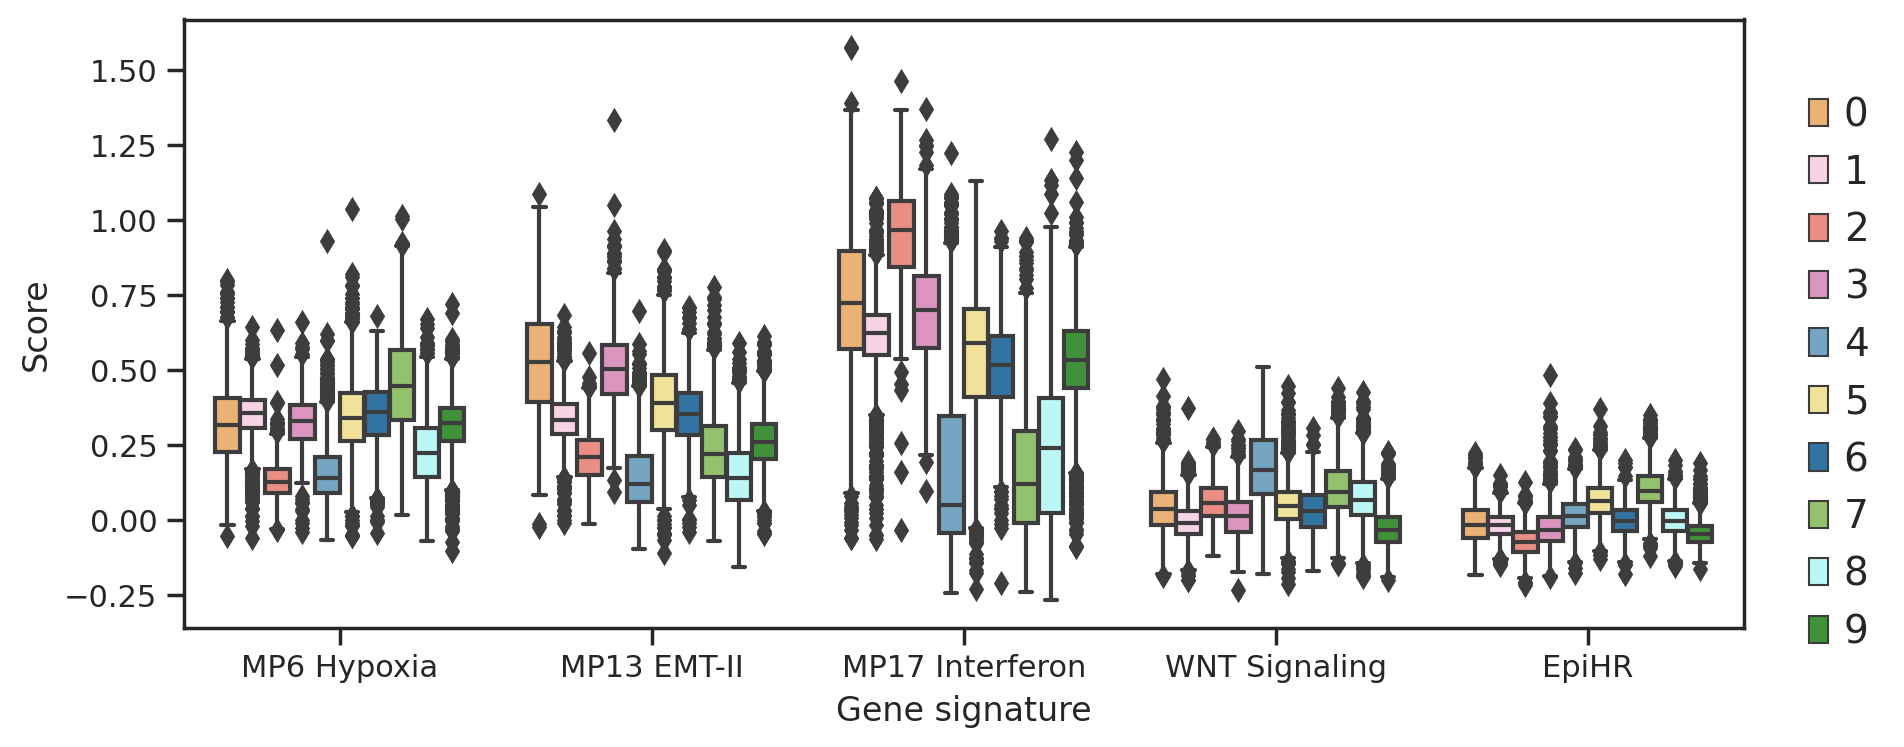

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
sns.boxplot(data=sign_score_df_melt,
            x="Gene signature", 
            y="Score", 
            hue="segmentation_labels",
            palette=palette,
            ax=ax
           )
ax.legend(
          bbox_to_anchor=(1.09, 0.9), 
          loc='upper right',
          fontsize=14,
          facecolor="white",
          edgecolor="white",
          ncol=1,
          borderaxespad=0.0,
          framealpha=0,
          frameon=False,
         )
plt.savefig(FIG2SAVE.joinpath("Boxplot_gene_signatures_cellular_neighbourhoods.pdf"), 
            dpi=DPI, format="pdf", 
            bbox_inches="tight")
plt.show()

### Percentage cellular neighbourhoods across samples

In [15]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

segmentation_labels          0          1          2          3          4  \
Sample                                                                       
CRC08_LM_VISIUM       2.852349   0.000000   0.000000   0.083893  32.298658   
CRC09_LM_VISIUM       0.106724   0.106724  74.066169   0.640342  15.901814   
CRC11_LM_VISIUM      15.219842   0.000000   9.977452   0.281849  18.827508   
P3_liver              1.159296  10.090167   0.042937  11.399742  19.085444   
P13_Liver_ST          1.907998  33.795086   0.000000   4.992159   0.784109   
ST_LM_4              10.776673   7.901102   0.000000   8.116098   4.971782   

segmentation_labels          5          6          7          8          9  
Sample                                                                      
CRC08_LM_VISIUM       7.969799   0.000000  32.802013  23.993289   0.000000  
CRC09_LM_VISIUM       0.533618   0.106724   1.173959   7.363927   0.000000  
CRC11_LM_VISIUM       9.582864   0.225479   6.820744  39.064262   0

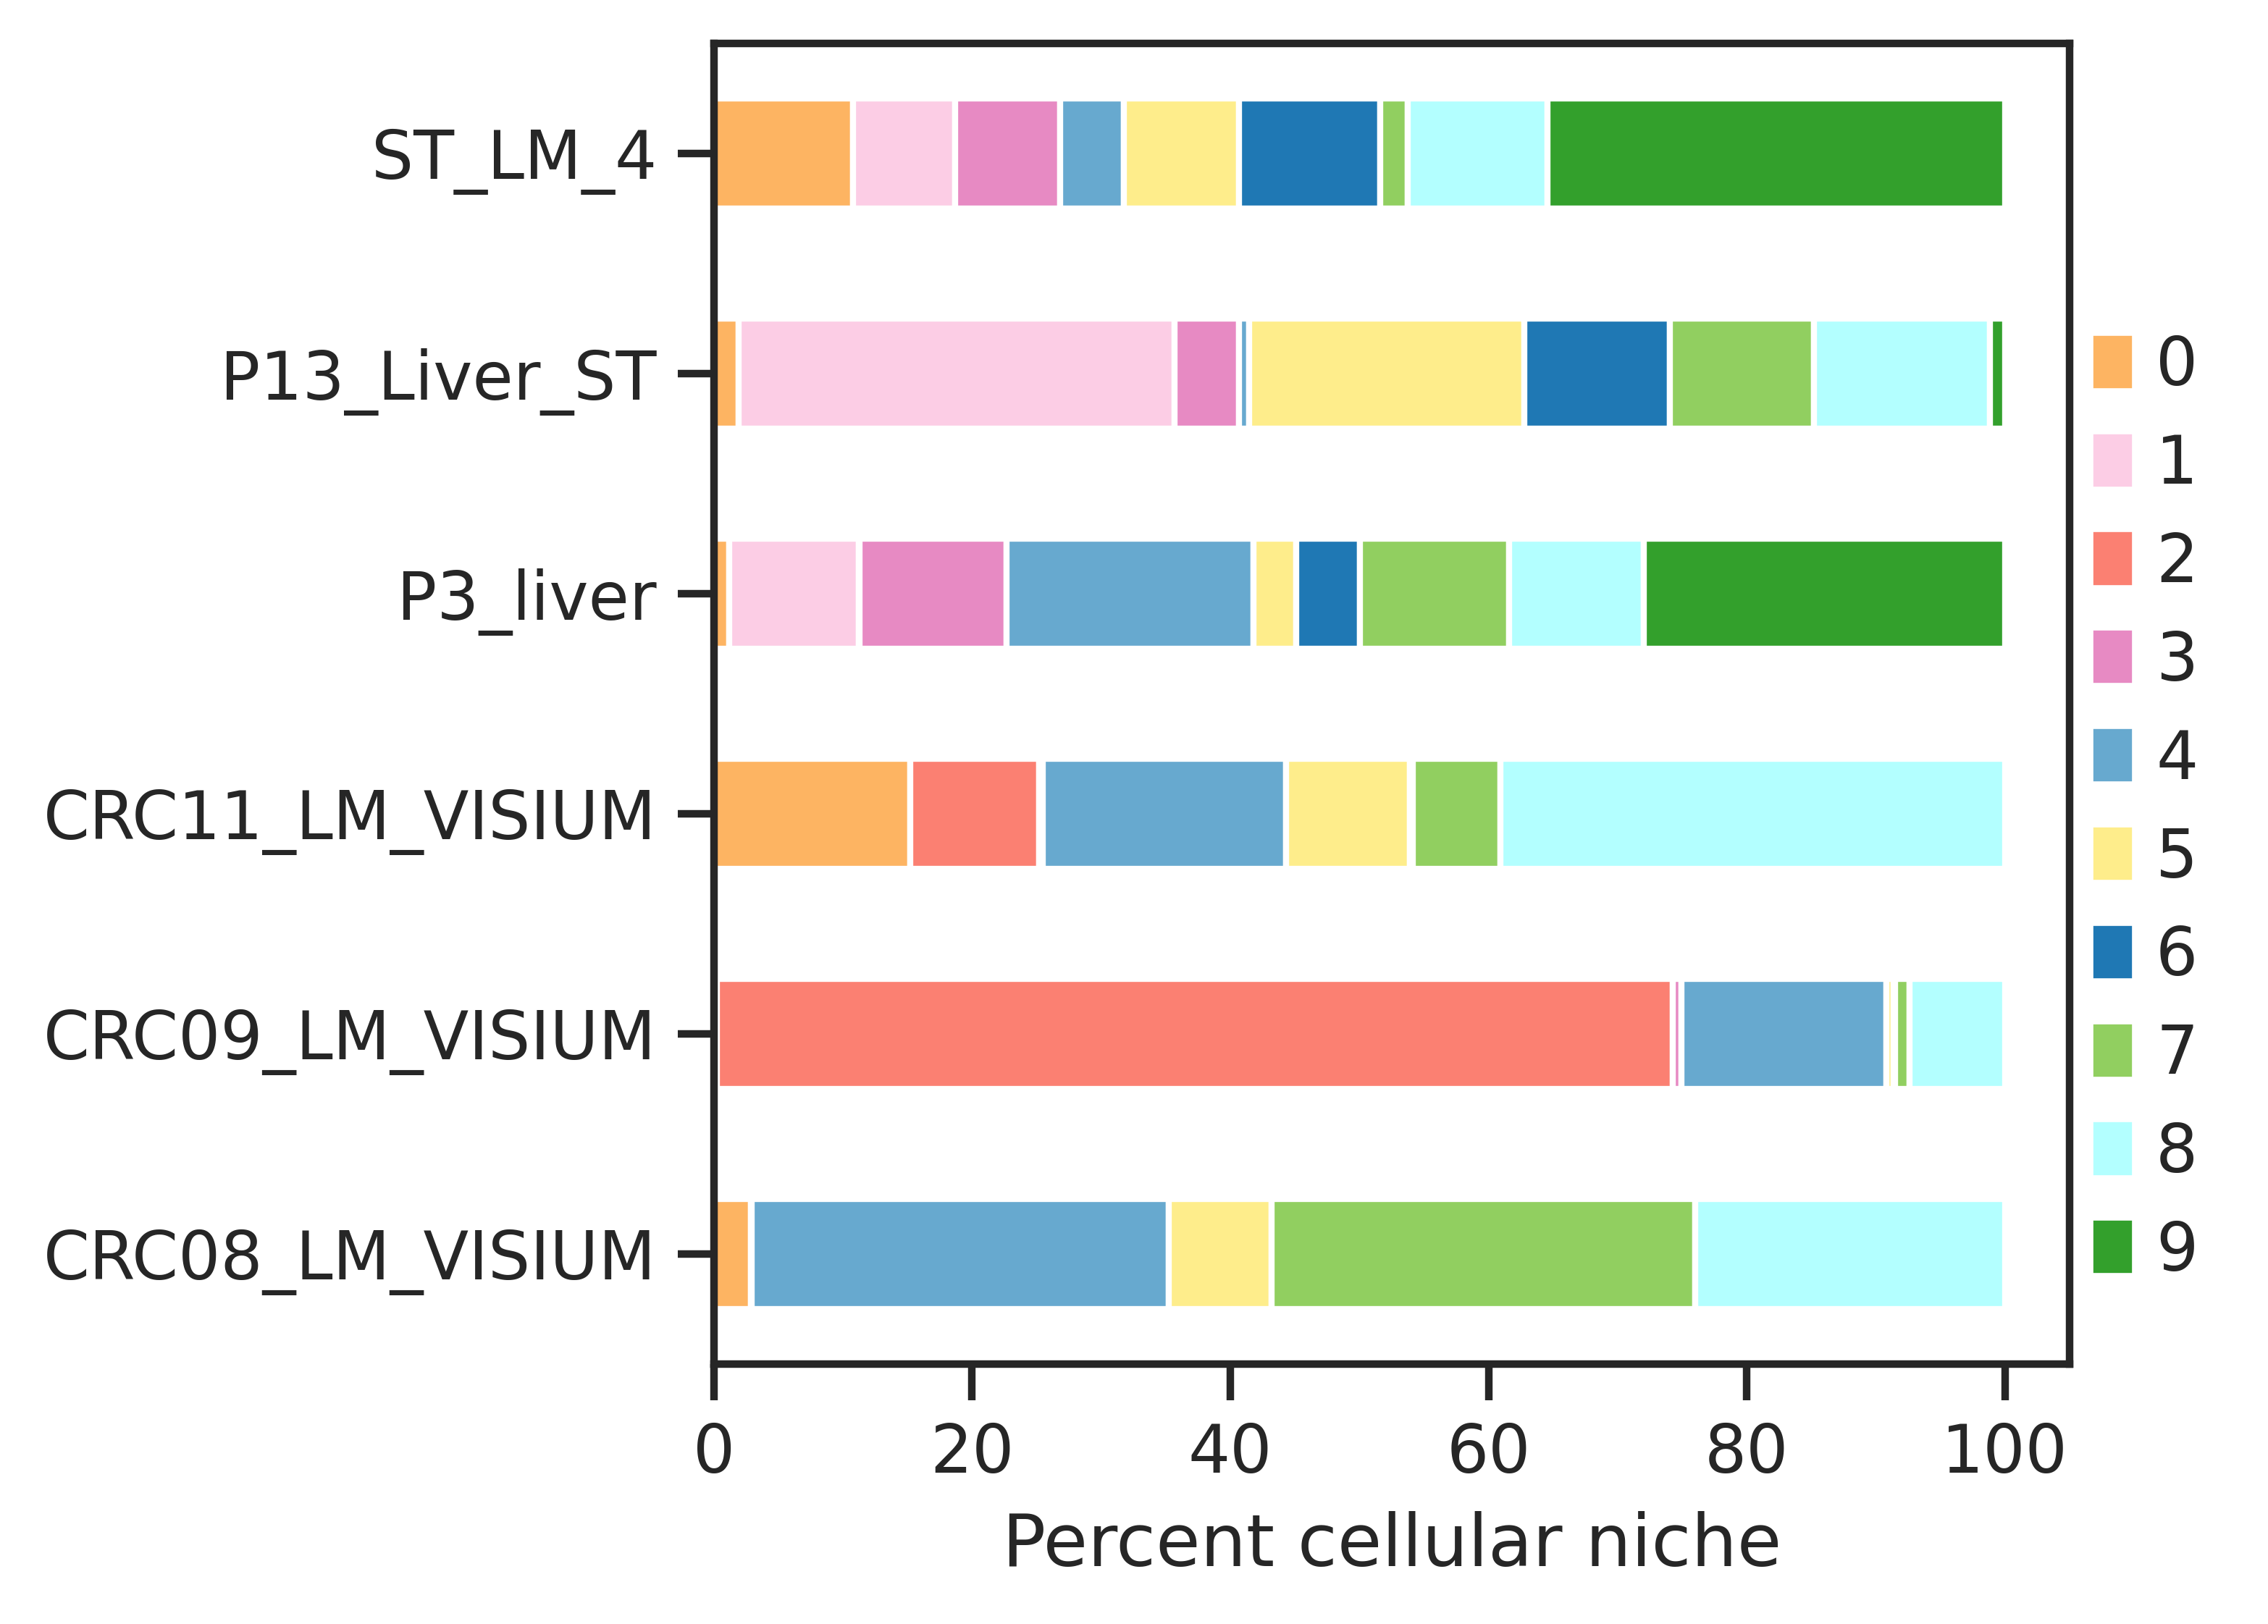

In [27]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata_microenv.obs["segmentation_labels"].cat.categories.values.tolist(),
        adata_microenv.uns["segmentation_labels_colors"],
    )
)

proportion_cells_patient(
    adata_microenv.obs,
    groupby_labels=["Sample", "segmentation_labels"],
    xlabel="Percent cellular niche",
    ylabel="",
    colors=color_dict,
    figname="sample_cellular_neighbourhoods_proportion.pdf",
)

In [12]:
adata_microenv.obs['Therapy'] = np.where(adata_microenv.obs['Sample']=='ST_LM_4', 'NAC', 'untreated')

segmentation_labels          0          1         2         3          4  \
Therapy                                                                    
NAC                  10.776673   7.901102  0.000000  8.116098   4.971782   
untreated             3.487527  14.240736  7.047711  5.925567  14.426415   

segmentation_labels          5          6          7          8          9  
Therapy                                                                     
NAC                   8.922333  10.937920   2.123085  10.830422  35.420586  
untreated            10.010495   5.384677  11.996448  16.598046  10.882377  


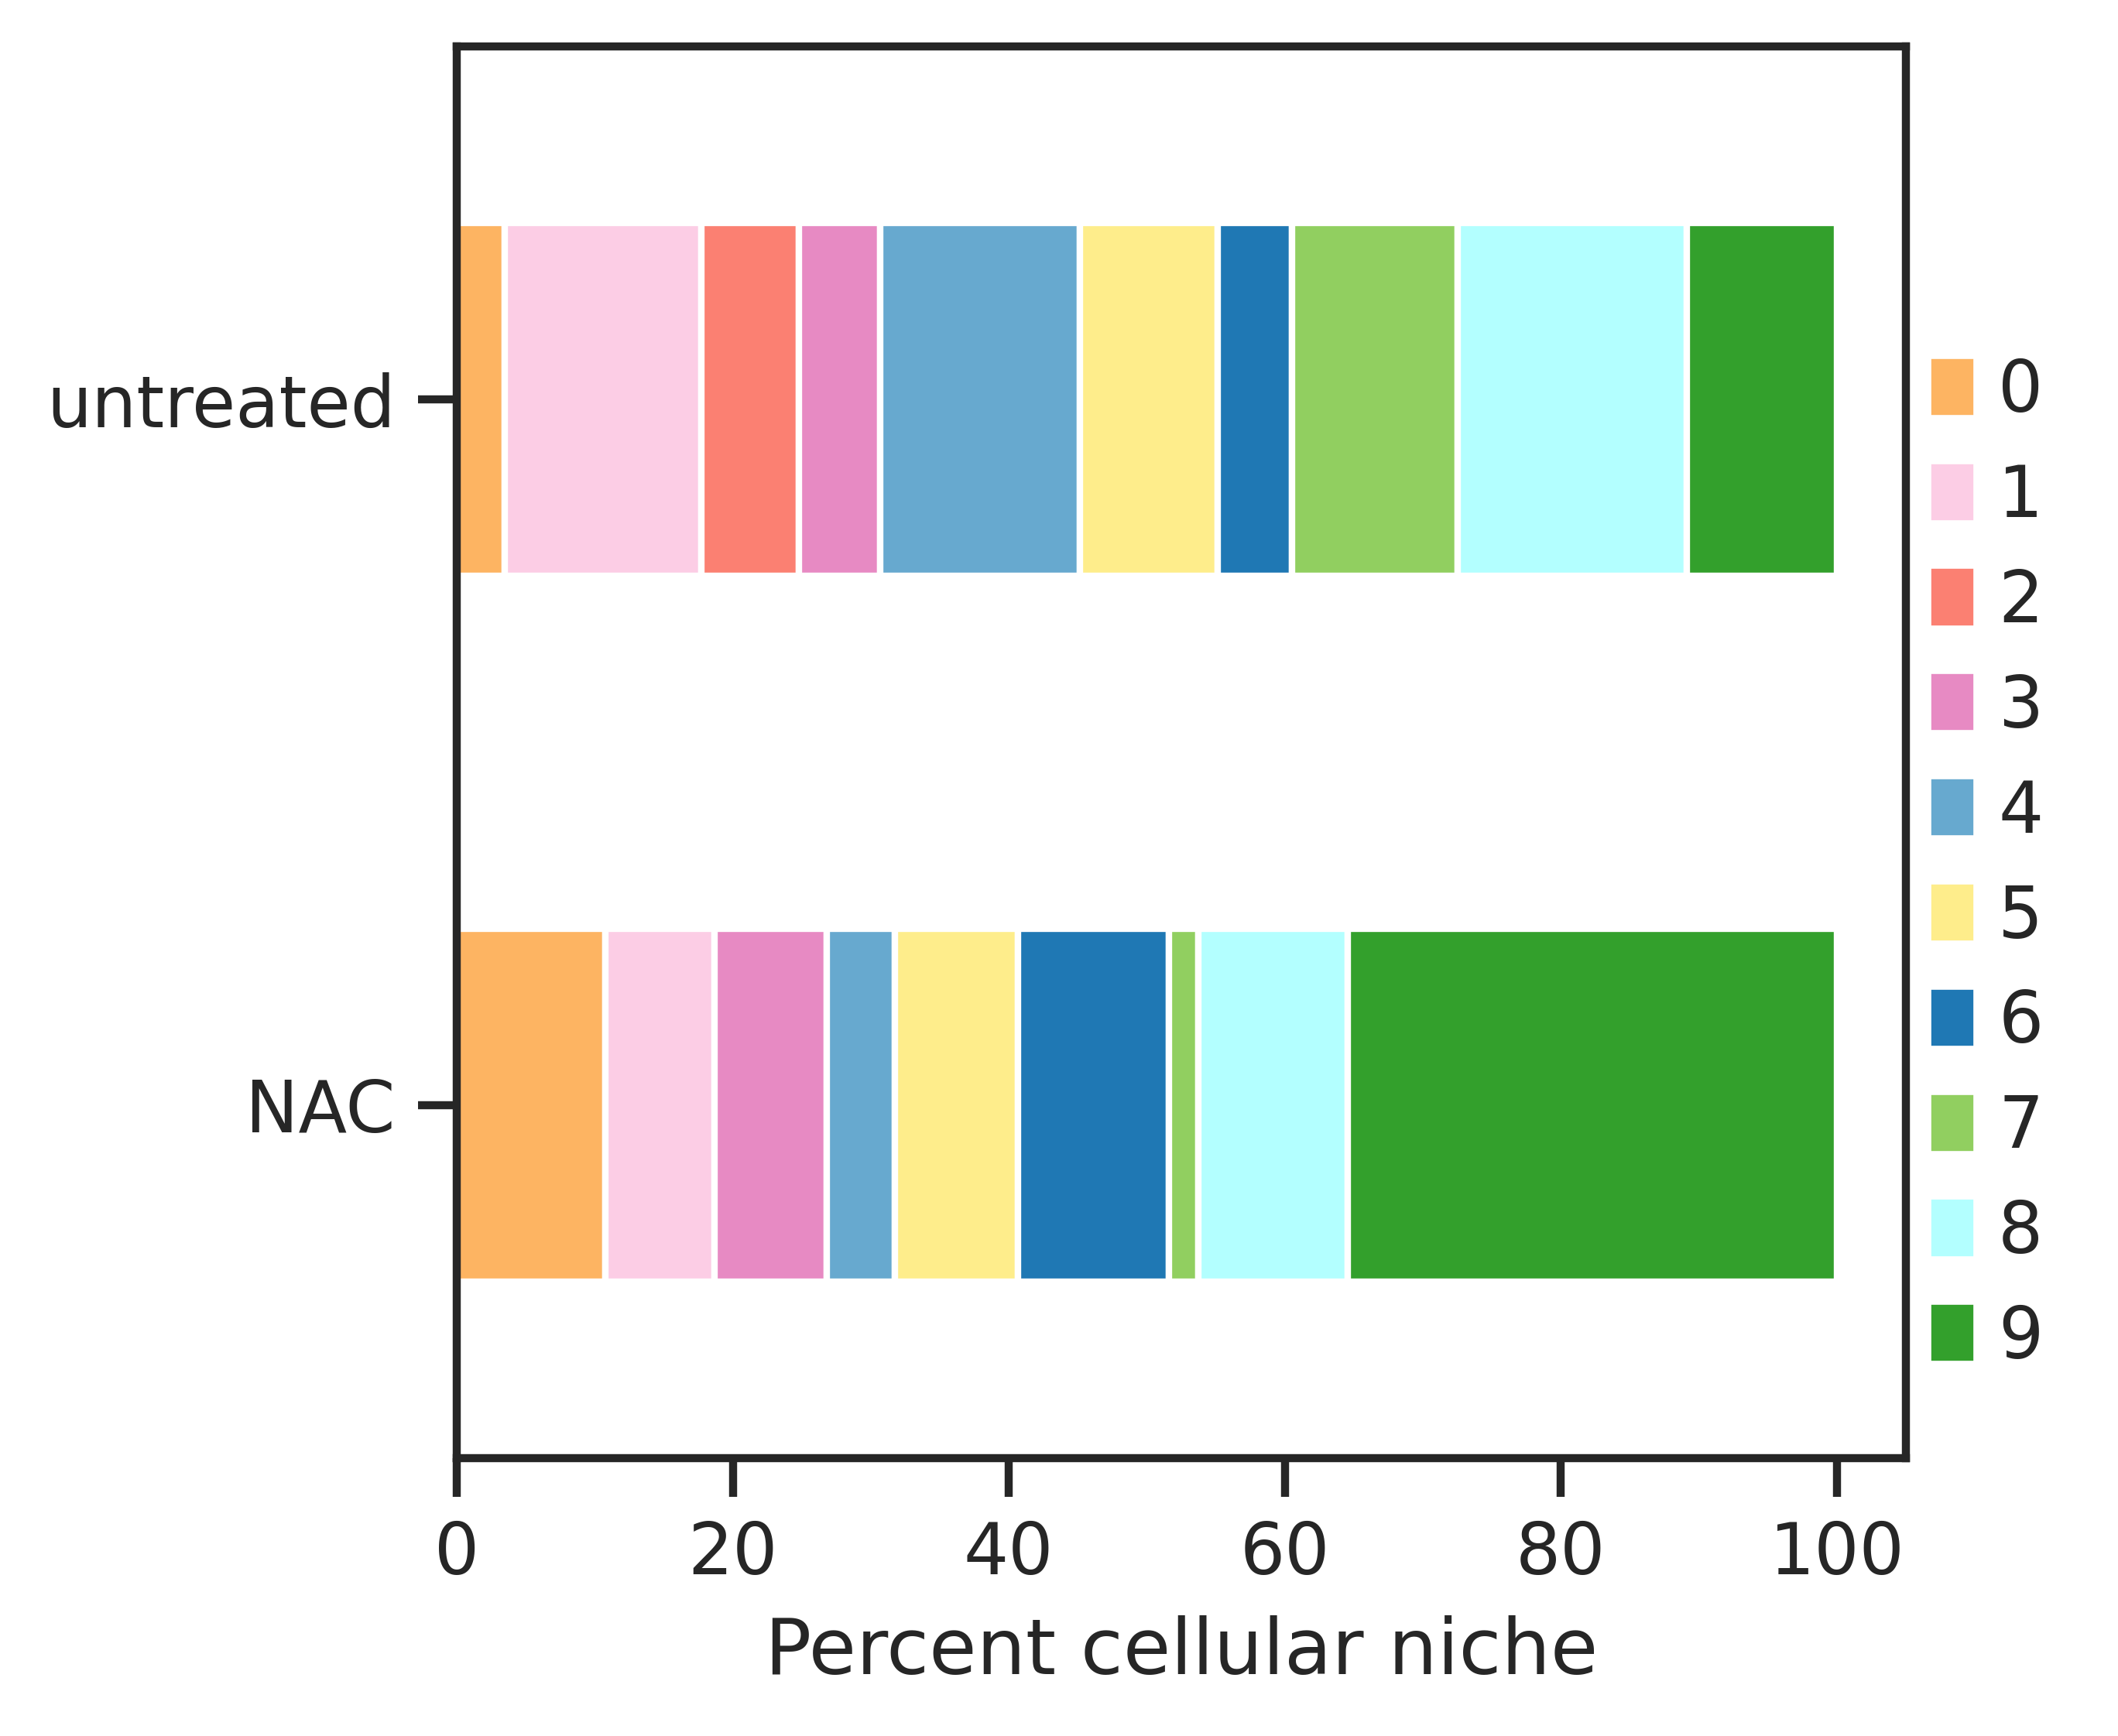

In [16]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata_microenv.obs["segmentation_labels"].cat.categories.values.tolist(),
        adata_microenv.uns["segmentation_labels_colors"],
    )
)

proportion_cells_patient(
    adata_microenv.obs,
    groupby_labels=["Therapy", "segmentation_labels"],
    xlabel="Percent cellular niche",
    ylabel="",
    colors=color_dict,
    figname="therapy_cellular_neighbourhoods_proportion.pdf",
)